In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# IMPORTING MODULES


In [1]:
import h5py

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import scipy as sp
import random
import nilearn as nl
from nilearn import datasets
from nilearn import plotting
from nilearn import image
import nibabel as nib
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import torch

import lightgbm as lgb
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Reading data

In [2]:
train = pd.read_csv('/kaggle/input/trends-assessment-prediction/train_scores.csv').sort_values(by='Id')

loadings = pd.read_csv('/kaggle/input/trends-assessment-prediction/loading.csv')

fnc = pd.read_csv('/kaggle/input/trends-assessment-prediction/fnc.csv')

sample = pd.read_csv('/kaggle/input/trends-assessment-prediction/sample_submission.csv')

reveal = pd.read_csv('/kaggle/input/trends-assessment-prediction/reveal_ID_site2.csv')

ICN = pd.read_csv('/kaggle/input/trends-assessment-prediction/ICN_numbers.csv')

In [3]:
!wget https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii

--2020-04-26 06:06:52--  https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Chaogan-Yan/DPABI/master/Templates/ch2better.nii [following]
--2020-04-26 06:06:52--  https://raw.githubusercontent.com/Chaogan-Yan/DPABI/master/Templates/ch2better.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35193272 (34M) [application/octet-stream]
Saving to: ‘ch2better.nii’

ch2better.nii       100%[===================>]  33.56M  69.7MB/s    in 0.5s    

2020-04-26 06:06:53 (69.7 MB/s) - ‘ch2better.nii’ saved [35193272/35193272]



# IMPORTANT VISUALS OF BRAIN


In [4]:
nii_loc = "/kaggle/input/trends-assessment-prediction/fMRI_mask.nii"
nii_loc2 = "/kaggle/input/trends-assessment-prediction/fMRI_train/10031.mat"

In [5]:
mat = h5py.File('/kaggle/input/trends-assessment-prediction/fMRI_train/10031.mat','r')
mat.keys()

<KeysViewHDF5 ['SM_feature']>

In [6]:
sample = mat['SM_feature']

In [8]:
sample.shape

(53, 52, 63, 53)

In [17]:
array = sample[()]
array.shape

(53, 52, 63, 53)

In [18]:
print(array.min(),array.max(),array.mean())

-7.991969108581543 11.066198348999023 0.039607786689485135


In [10]:
# one motor contrast map from NeuroVault

maskni = nl.image.load_img(nii_loc)
subjectimage = nl.image.new_img_like(nii_loc, array, affine=maskni.affine, copy_header=True)


Dataset created in /root/nilearn_data/neurovault



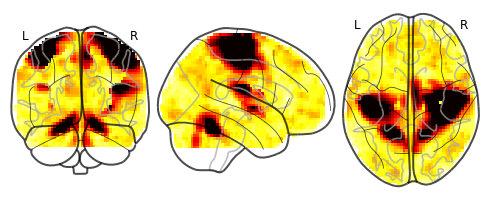

In [11]:
motor_images = datasets.fetch_neurovault_motor_task()
img = motor_images.images[0]

niiplot = plotting.plot_glass_brain(img)
niiplot

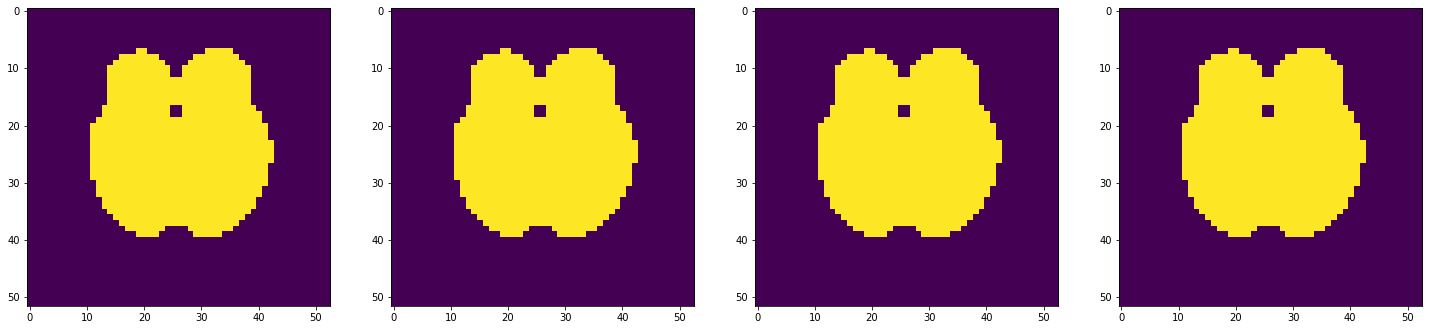

In [12]:
mat, ax = plt.subplots(1,4)
mat.set_size_inches(25, 10)
for i in range(4):
    Temp = array[i*10, :, 10, :] !=0  
    ax[i].imshow(Temp)
plt.show()

In [19]:
array = np.moveaxis(array, [0,1,2,3], [3,2,1,0])
array

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [20]:
smri = 'ch2better.nii'
num_components = subjectimage.shape[-1]

/opt/conda/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))
/opt/conda/lib/python3.6/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


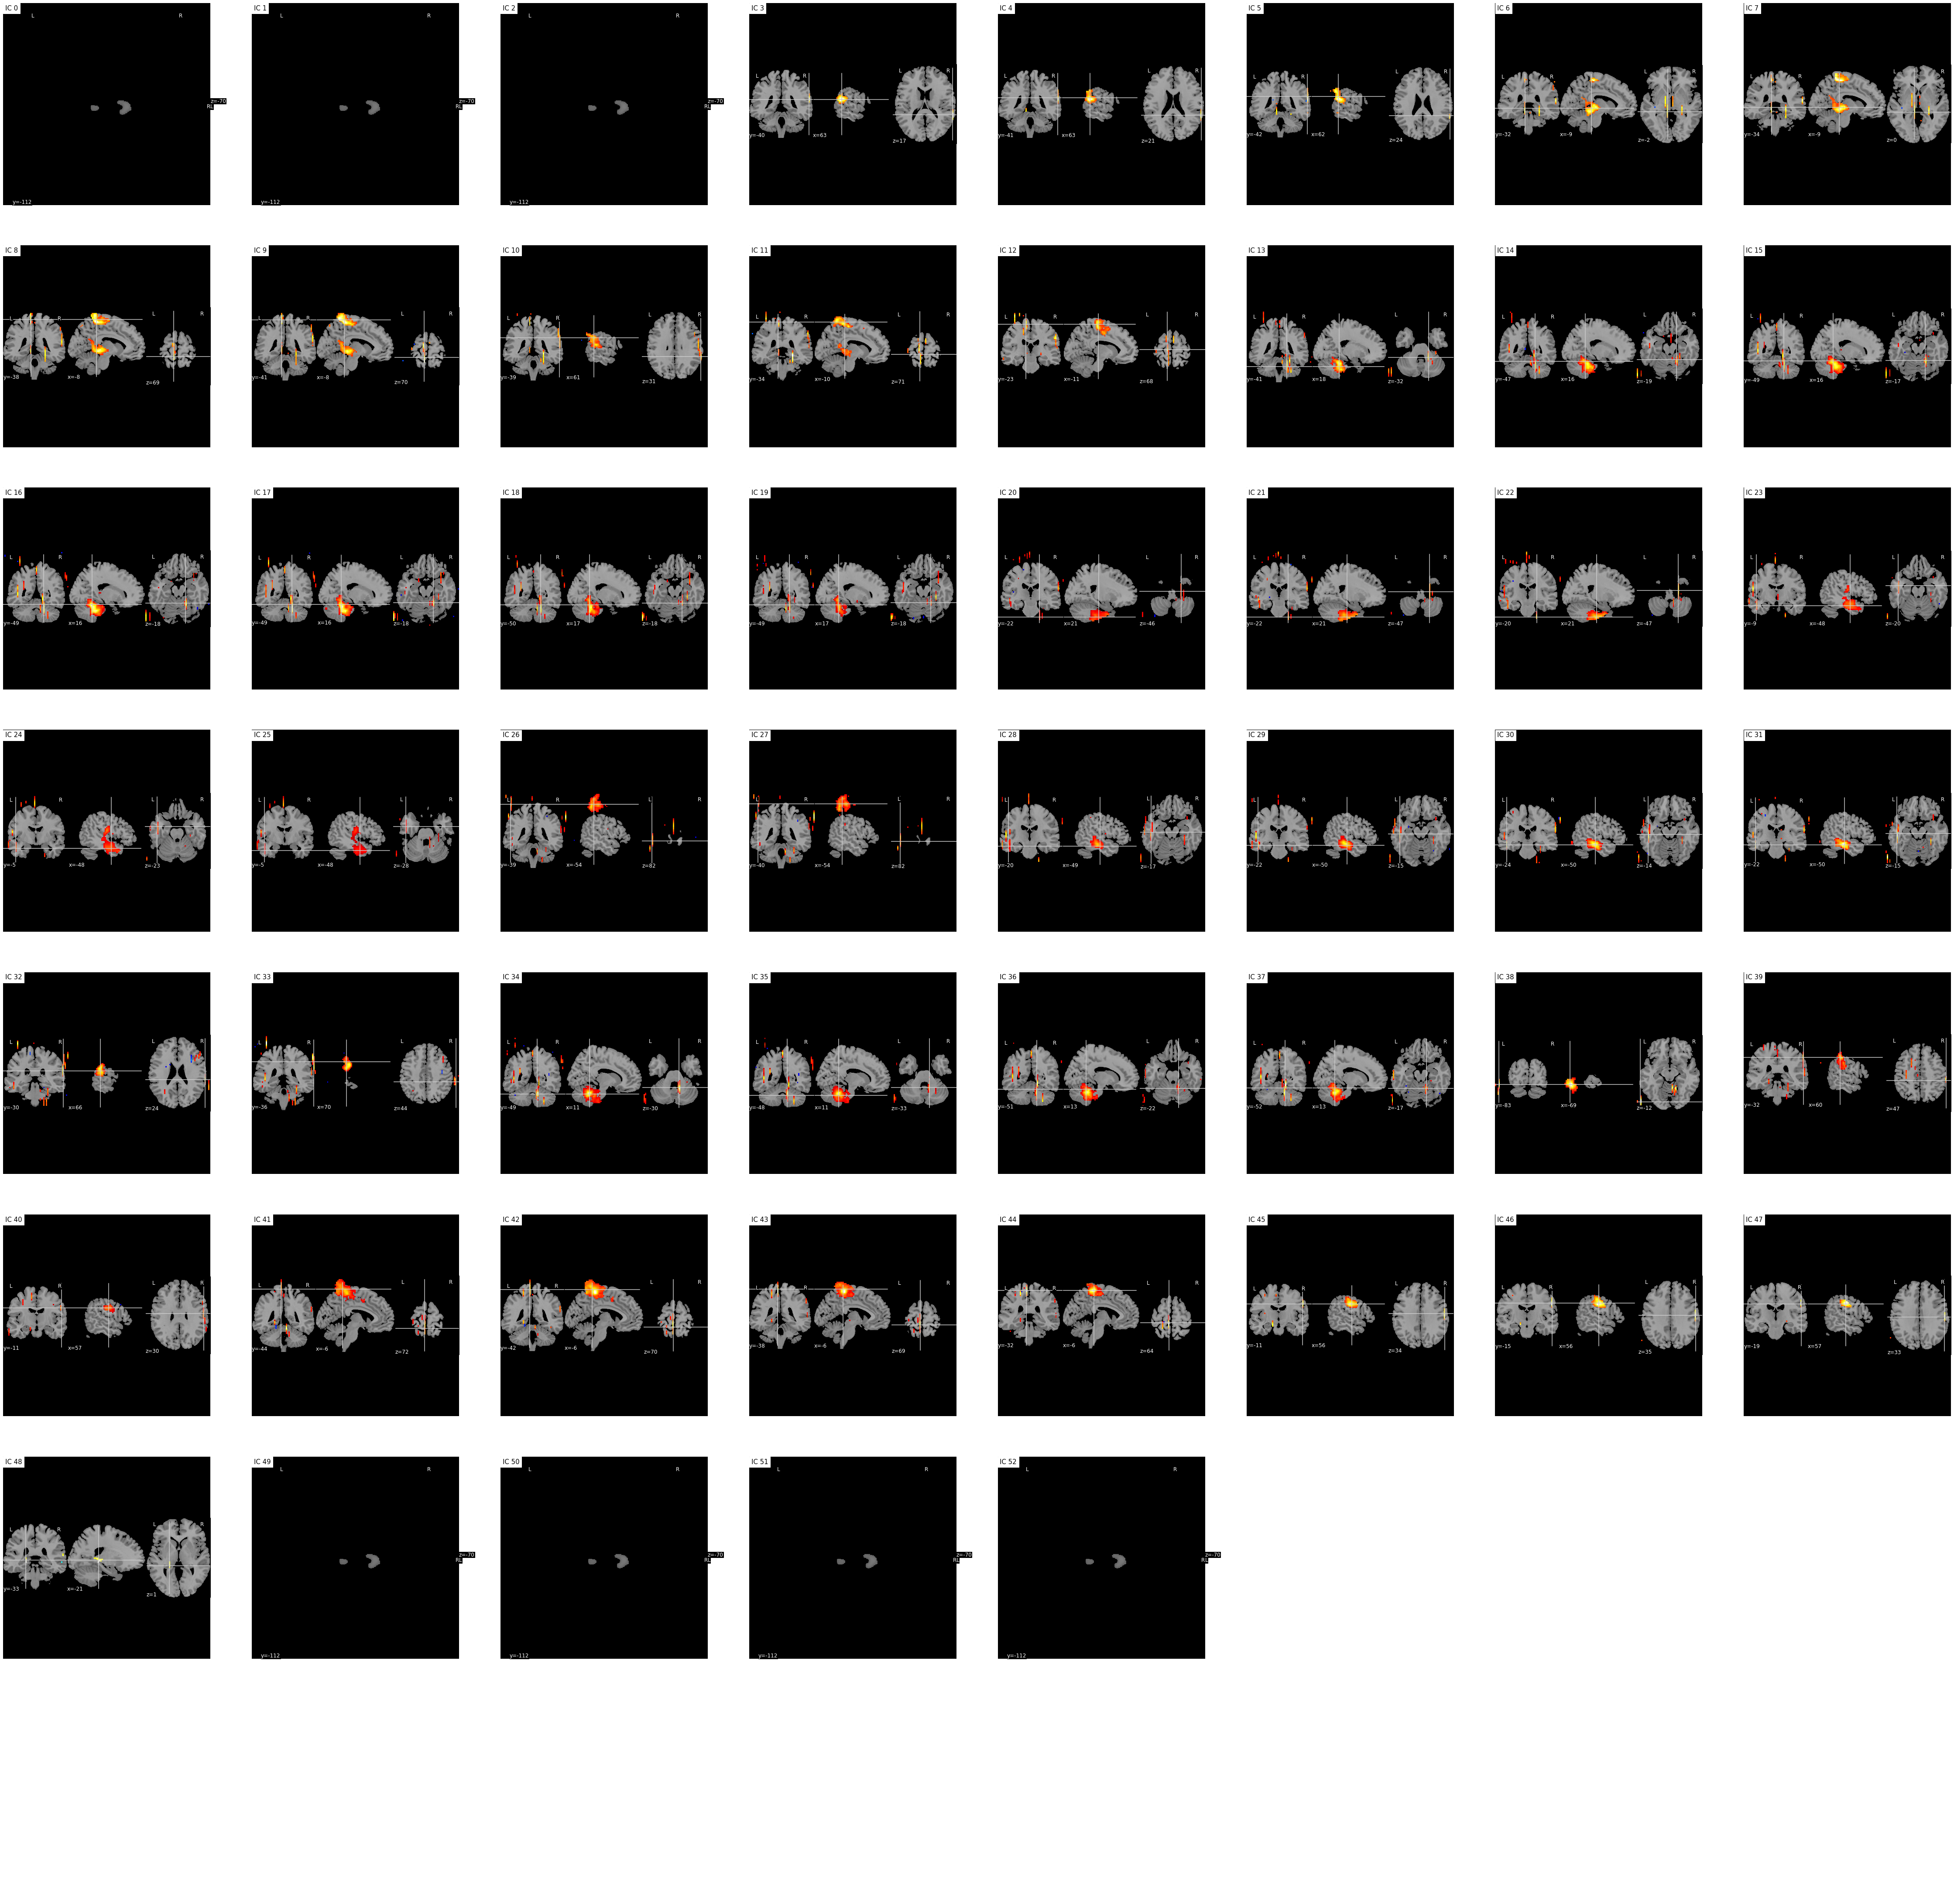

In [21]:
grid_size = int(np.ceil(np.sqrt(num_components)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1
for i, cur_img in enumerate(nl.image.iter_img(subjectimage)):
    col = i % grid_size
    if col == 0:
        row += 1
    nlplt.plot_stat_map(cur_img, bg_img=smri, title="IC %d" % i, axes=axes[row, col], threshold=3, colorbar=False)

In [22]:
array.reshape(53*52, 53*63)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Data Cleansing


In [23]:
train.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [24]:
reveal.head

<bound method NDFrame.head of         Id
0    10012
1    10014
2    10020
3    10034
4    10059
..     ...
505  21658
506  21675
507  21678
508  21686
509  21749

[510 rows x 1 columns]>

In [25]:
ICN.head()

,ICN_number
0,69
1,53
2,98
3,99
4,45


In [26]:
fnc.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
3,10004,0.132793,0.258255,0.490769,0.342717,0.091112,0.107969,0.029220,-0.026237,0.094742,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
4,10005,0.291921,0.251254,0.416470,0.511719,-0.362626,-0.164710,-0.289059,-0.015537,-0.087316,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898


In [27]:
train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


In [28]:
train_ids = sorted(loadings[loadings['Id'].isin(train.Id)]['Id'].values)
test_ids = sorted(loadings[~loadings['Id'].isin(train.Id)]['Id'].values)


predictions = pd.DataFrame(test_ids, columns=['Id'], dtype=str)
features = ('age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2')

In [29]:
data = pd.merge(loadings, train, on='Id').dropna()

X_train = data.drop(list(features), axis=1).drop('Id', axis=1)
y_train = data[list(features)]

X_test = loadings[loadings.Id.isin(test_ids)].drop('Id', axis=1)

# USING MODEL FOR PREDICTIONS


In [30]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5
)

cv = KFold(n_splits = 5, shuffle=True, random_state=29)

grid = {
    'n_estimators':[5,10,20,100]
}

gs = GridSearchCV(model, grid, n_jobs=-1, cv=cv, verbose=1, scoring='neg_mean_absolute_error')

In [31]:
best_models = {}
for col in features:
    gs.fit(X_train, y_train[col])
    best_models[col] = gs.best_estimator_
    print(gs.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.2s finished


-8.054209997060312
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.6s finished


-7.92476993480818
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.8s finished


-8.993371837650056
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.2s finished


-8.67373272430174
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.1s finished


-9.265800645092556


In [32]:
for col in features:
    predictions[col] = best_models[col].predict(X_test)

In [33]:
def make_sub(predictions):
    features = ('age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2')
    _columns = (0,1,2,3,4)
    tests = predictions.rename(columns=dict(zip(features, _columns)))
    tests = tests.melt(id_vars='Id',value_vars=_columns,value_name='Predicted')
    tests['target'] = tests.variable.map(dict(zip(_columns, features)))
    tests['Id_'] = tests[['Id', 'target']].apply(lambda x: '_'.join((str(x[0]), str(x[1]))), axis=1)
  
    return tests.sort_values(by=['Id', 'variable'])\
              .drop(['Id', 'variable', 'target'],axis=1)\
              .rename(columns={'Id_':'Id'})\
              .reset_index(drop=True)\
              [['Id', 'Predicted']]

In [34]:
sub = make_sub(predictions)

In [35]:
sub

,Id,Predicted
0,10003_age,48.023004
1,10003_domain1_var1,49.035412
2,10003_domain1_var2,60.327465
3,10003_domain2_var1,48.965014
4,10003_domain2_var2,52.351165
...,...,...
29380,21753_age,36.309005
29381,21753_domain1_var1,45.811510
29382,21753_domain1_var2,59.649011
29383,21753_domain2_var1,42.326117


In [ ]:
sub.to_csv('firsttry.csv', index=False)